# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-nz4_ojwq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-nz4_ojwq
  Resolved https://github.com/huggingface/transformers to commit cd22550692cabffb037b7e5a956e8da3cbbb2b67
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 11.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.56.0.dev0-py3-none-any.whl size=12431919 sha256=c2fd61c093365f11d459b0d13a9528aab81222f78c979580153182157bb58462
  Stored in directory: /tmp/pip-ephem-wheel-cache-lrwjd0ao/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:


# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-08-17 05:57:42.493300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755410262.677420      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755410262.729177      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 8
MAX_SEQ_LENGTH   = 512
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.80  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.10  # test
RANDOM_STATE     = 42

assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [6]:
def clean_text(text):
    if text is None:
        return ""
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())
    return text

_PATIENT_ID_RE = re.compile(r'(?:p|patient)?(\d+)', re.IGNORECASE)

def extract_patient_id(xml_path):
    """
    IU-Xray XML filenames are often like 'CXRxxxx.xml' with patient/study info inside.
    The XML has a parentImage id such as 'CXR1234_IM-xxxx-xxxx' and a patient id in text nodes.
    If not explicit, fall back to numeric stem grouping. This keeps patients grouped, preventing leakage.
    """
    # Try to parse from XML PatientID if present; fallback to filename stem numeric cluster
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        pid_node = root.find(".//MedlineCitation/Article/ArticleTitle")  # no patient id here typically
        # IU-Xray provides patient identifiers in DICOM-derived fields sparsely; safer to derive from image ids
        # Find first parentImage id and extract leading integer cluster
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id')  # e.g., 'CXR1000_IM-0001-3001'
            # Derive patient bucket from the numeric group right after CXR
            m = re.search(r'CXR(\d+)', pid_guess or '')
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    # Fallback based on filename digits
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def create_data_manifest(xml_dir, img_dir, tokenizer, max_seq_length=512):
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text if findings_node is not None else "")

            if not findings_text and not impression_text:
                continue

            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} {tokenizer.eos_token}"

            patient_id = extract_patient_id(xml_file)

            image_nodes = root.findall(".//parentImage")
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    # Treat each image as its own record; same report duplicated
                    manifest.append({
                        'patient_id': patient_id,
                        'image_path': image_path,
                        'report_text': full_report
                    })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest

In [7]:
class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_path = item['image_path']

        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)

        tokenized_report = self.tokenizer(
            report_text,
            truncation=True,
            max_length=self.max_seq_length
        )

        input_ids = tokenized_report['input_ids']
        labels = input_ids.copy()

        return {
            "image": image_tensor,
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "image_path": image_path,
            "patient_id": item['patient_id']
        }

In [8]:
def custom_collate_fn(batch):
    images = [item['image'] for item in batch]
    image_paths = [item['image_path'] for item in batch]
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list    = [item['labels'] for item in batch]

    images = torch.stack(images, dim=0)

    padded_inputs = tokenizer.pad(
        {'input_ids': input_ids_list},
        padding='longest',
        return_tensors='pt'
    )

    padded_labels = tokenizer.pad(
        {'input_ids': labels_list},
        padding='longest',
        return_tensors='pt'
    )['input_ids']

    pad_token_id = tokenizer.pad_token_id
    padded_labels[padded_labels == pad_token_id] = -100

    return {
        'image': images,
        'input_ids': padded_inputs['input_ids'],
        'attention_mask': padded_inputs['attention_mask'],
        'labels': padded_labels,
        'image_path': image_paths
    }

In [9]:
from transformers import GPT2TokenizerFast

special_tokens_dict = {
    'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']
}
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token  # Keep this line for consistent padding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# **Loaded Data Visualization**

Scanning 3955 XML files to create manifest...
Total per-image records in manifest: 7430

Data successfully split (patient-level, no leakage):
Unique patients total: 3826
Train patients: 3061, Val patients: 383, Test patients: 382
Training samples:   5932
Validation samples: 744
Test samples:       754

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'labels', 'image_path'])
Image tensor shape:      torch.Size([8, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 110])
Attention mask shape:    torch.Size([8, 110])
Labels tensor shape:     torch.Size([8, 110])


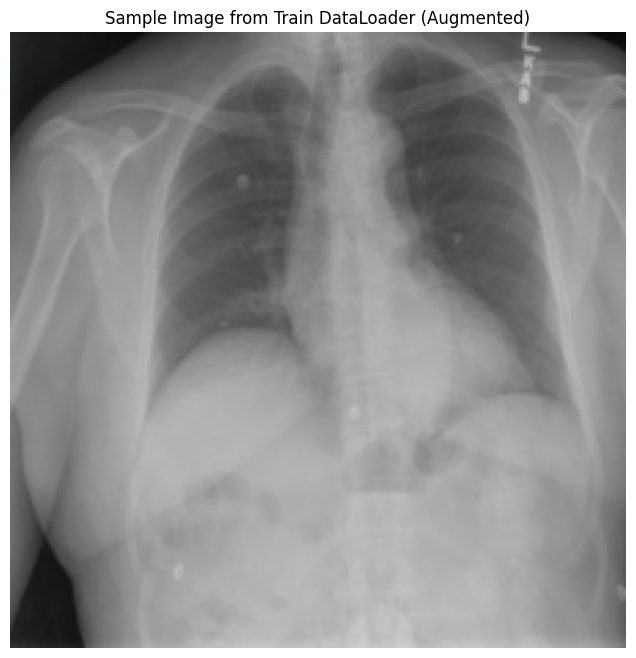


--- Sample Report from the same item (Decoded from Tensors) ---
 the heart size is normal. tortuous aorta. otherwise the mediastinal contour is within normal limits. low lung volumes. mild elevation of the right hemidiaphragm. there is streaky opacity within the right lower lobe. there are no nodules or masses. no visible pneumothorax. no visible pleural fluid. the are grossly normal. there is no visible free intraperitoneal air under the diaphragm.  streaky right lower lobe infiltrate versus atelectasis. 
--------------------------------------------------


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(
    #     degrees=7,
    #     translate=(0.05, 0.05),
    #     scale=(0.95, 1.05),
    #     shear=None
    # ),
    # transforms.ColorJitter(
    #     brightness=0.1,
    #     contrast=0.1,
    #     saturation=0.0,  # avoid unrealistic color shifts
    #     hue=0.0
    # ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =========================
# Build manifest
# =========================
full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH, tokenizer, max_seq_length=MAX_SEQ_LENGTH)
print(f"Total per-image records in manifest: {len(full_manifest)}")

# =========================
# Patient-level split (R2Gen-style: 70/10/20; no leakage)
# =========================
# Collect unique patients
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
# Ensure total equals n_patients
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training samples:   {len(train_manifest)}")
print(f"Validation samples: {len(val_manifest)}")
print(f"Test samples:       {len(test_manifest)}")

# =========================
# Datasets & DataLoaders
# =========================
train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest, tokenizer, eval_transform,  max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest, tokenizer, eval_transform,  max_seq_length=MAX_SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, collate_fn=custom_collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

print("\nPyTorch DataLoaders are ready!")

# =========================
# Verify one sample batch
# =========================
print("\n--- Verifying a sample batch from the train_loader ---")
sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['image'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")

idx_to_show = random.randint(0, sample_batch['image'].size(0) - 1)
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

img_tensor = sample_batch['image'][idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_display = (img_tensor * std) + mean
img_display = transforms.ToPILImage()(img_display)

plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.title("Sample Image from Train DataLoader (Augmented)")
plt.axis('off')
plt.show()

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)

# **MambaVision**

In [11]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W) or list of PIL images
        Output: pooled features (B, 640), raw stage features
        """
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pooled feature shape: torch.Size([8, 640])
Stage 4 feature map shape: torch.Size([8, 640, 7, 7])


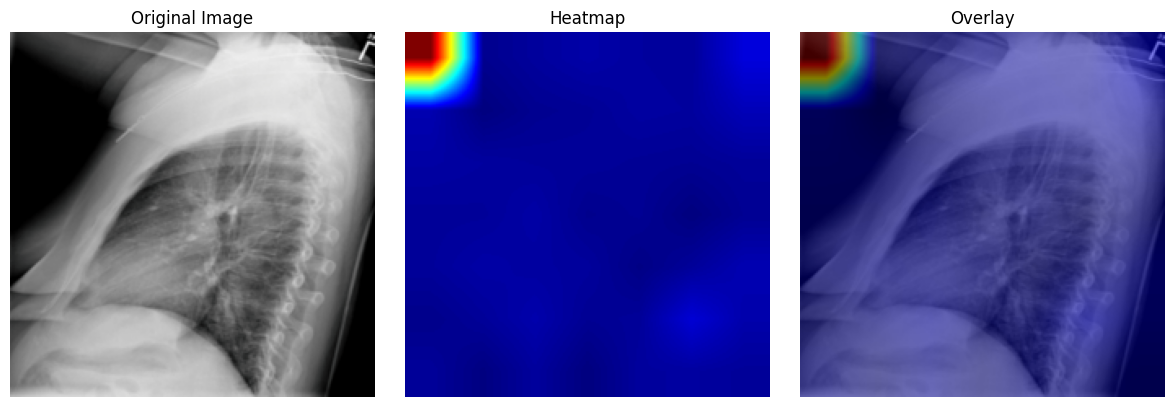

In [12]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)
print(f"Stage 4 feature map shape: {stage_feats[3].shape}")  # (B, 640, 7, 7)

# === Visualize one image with heatmap overlay ===
idx = 0
image_tensor = images[idx].cpu()
feature_map = stage_feats[3][idx]  # (640, 7, 7)

# === Generate heatmap ===
activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
activation_map = np.maximum(activation_map, 0)
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
activation_map = cv2.resize(activation_map, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# === Unnormalize image for visualization ===
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = (image_tensor * std) + mean
img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
img = np.uint8(255 * img)

# === Overlay heatmap ===
overlay = np.uint8(0.5 * img + 0.5 * heatmap)

# === Display ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

# **Projection layer**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768, hidden_dim=768, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(vision_dim, hidden_dim)
        self.act = nn.GELU()
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, gpt2_emb_dim)
        self.ln2 = nn.LayerNorm(gpt2_emb_dim)
        self.dropout = nn.Dropout(dropout)

        # If vision_dim == gpt2_emb_dim, allow residual shortcut
        if vision_dim == gpt2_emb_dim:
            self.residual = True
        else:
            self.residual = False
            self.shortcut = nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        """
        vision_feat: Tensor of shape (B, vision_dim)
        Returns: Tensor of shape (B, gpt2_emb_dim)
        """
        x = self.fc1(vision_feat)
        x = self.act(x)
        x = self.ln1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.ln2(x)

        if self.residual:
            out = x + vision_feat  # residual if dims match
        else:
            out = x + self.shortcut(vision_feat)  # project to match dims

        return out

In [14]:
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)  # pooled_feats: (B, 640)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)

# === Instantiate Projection Layer ===
gpt2_emb_dim = 768  # or tokenizer/model config n_embd
proj_layer = VisualProjection(vision_dim=pooled_feats.shape[1], gpt2_emb_dim=gpt2_emb_dim).to('cuda')

# === Project visual features ===
with torch.no_grad():
    projected_feats = proj_layer(pooled_feats)  # (B, 768)

print(f"Projected feature shape: {projected_feats.shape}")  # (B, 768)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pooled feature shape: torch.Size([8, 640])
Projected feature shape: torch.Size([8, 768])


# **CustomGPT2**

In [15]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [16]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [17]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [18]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# **Main GPT2 Block**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        
    def resize_token_embeddings(self, new_num_tokens):
        """
        Resize token embeddings and lm_head when vocabulary size changes (e.g., after adding special tokens).
        """
        old_embeddings = self.wte
        old_num_tokens, embedding_dim = old_embeddings.weight.shape
    
        if new_num_tokens == old_num_tokens:
            return self.wte
    
        # 1. New embedding layer
        new_embeddings = nn.Embedding(new_num_tokens, embedding_dim).to(old_embeddings.weight.device)
        nn.init.normal_(new_embeddings.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_to_copy, :] = old_embeddings.weight.data[:num_to_copy, :]
        self.wte = new_embeddings
    
        # 2. New lm_head layer
        old_lm_head = self.lm_head
        new_lm_head = nn.Linear(embedding_dim, new_num_tokens, bias=False).to(old_lm_head.weight.device)
        nn.init.normal_(new_lm_head.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_lm_head.weight.size(0), new_num_tokens)
        new_lm_head.weight.data[:num_to_copy, :] = old_lm_head.weight.data[:num_to_copy, :]
        self.lm_head = new_lm_head
    
        return self.wte


    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None, labels=None):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        for block in self.blocks:
            x = block(x, encoder_hidden_states)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100 # Change to your tokenizer's pad_token_id if it's not 0!
            )
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)


# **Main Block**

In [20]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2):
        super().__init__()
        self.vision_encoder = vision_encoder    # MambaVisionEncoder
        self.proj_layer = proj_layer            # VisualProjection
        self.gpt2 = custom_gpt2                 # Your custom GPT-2, built from GPT2Block

    def forward(self, images, input_ids, attention_mask=None, labels=None):
        # 1. Vision feature extraction
        pooled_feats, _ = self.vision_encoder(images)           # (B, vision_dim)
        visual_emb = self.proj_layer(pooled_feats).unsqueeze(1) # (B, 1, gpt2_emb_dim)

        # 2. Pass to your custom GPT-2 model as cross-attention memory
        #    Assumes that your model's forward signature matches this usage
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels
        )
        return outputs  # outputs can include logits, loss, etc.
    def freeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

    def unfreeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = True

    def freeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = False

    def unfreeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = True

    def freeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = False

    def unfreeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class):
        """
        - vision_encoder: your vision encoder instance
        - proj_layer: your projection layer instance
        - gpt2_config: config for your custom GPT2 (define embed size etc.)
        - custom_gpt2_class: pass your custom GPT2 model class (e.g., MyCustomGPT2)
        """
        # Instantiate custom GPT-2 model
        custom_gpt2 = custom_gpt2_class(gpt2_config)
        custom_gpt2.resize_token_embeddings(len(tokenizer))
        # Load HuggingFace GPT-2 weights into your custom model
        from transformers import GPT2LMHeadModel
        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]  # keys absent/present only in your custom version

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            # Transpose if needed
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])
        custom_gpt2.load_state_dict(custom_sd, strict=False)
        

        return cls(vision_encoder, proj_layer, custom_gpt2)


# **Trainer Class**

In [21]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re

class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        """
        vl_model: VisionLanguageWrapper instance (integrates vision encoder, projection, custom GPT2)
        tokenizer: your tokenizer (must have .bos_token_id and .eos_token_id)
        train_config: SimpleNamespace/args for training params (epochs, device, lr, batch_size, etc.)
        dls: tuple of (train_dataloader, val_dataloader)
        """
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        total_steps = len(self.train_dl)

        self.scaler = torch.cuda.amp.GradScaler()
        self.optim = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.vl_model.parameters()),
            lr=train_config.lr / 25.
        )
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=train_config.lr,
            epochs=train_config.epochs,
            steps_per_epoch=total_steps
        )

        # metrics dataframe
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity',
                      'val_loss','val_perplexity',
                      'ema_loss']] = None

        # EMA tracker
        self.ema_loss = None
        self.ema_alpha = getattr(train_config, 'ema_alpha', 0.1)  # smoothing factor

    def update_ema(self, loss_val):
        """Update exponential moving average loss."""
        if self.ema_loss is None:
            self.ema_loss = loss_val
        else:
            self.ema_loss = self.ema_alpha * loss_val + (1 - self.ema_alpha) * self.ema_loss
        return self.ema_loss

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.vl_model.state_dict()
        torch.save(sd, self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt')
        self.vl_model.load_state_dict(sd)

    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        total_batches = len(self.train_dl)

        for batch_idx, batch in enumerate(self.train_dl):
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.amp.autocast('cuda'):
                outputs = self.vl_model(images, input_ids,
                                        attention_mask=attention_mask,
                                        labels=labels)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()
            self.sched.step()
            self.optim.zero_grad(set_to_none=True)

            running_loss += loss.item()
            self.update_ema(loss.item())

            del images, input_ids, labels, loss

        train_loss = running_loss / total_batches
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss','train_perplexity','ema_loss']] = (
            train_loss, train_pxp, self.ema_loss
        )
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | PPL: {train_pxp:.4f} | EMA Loss: {self.ema_loss:.4f}")

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        total_batches = len(self.val_dl)

        for batch in self.val_dl:
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.amp.autocast('cuda'):
                outputs = self.vl_model(images, input_ids,
                                        attention_mask=attention_mask,
                                        labels=labels)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs
                running_loss += loss.item()

            del images, input_ids, labels, loss

        val_loss = running_loss / total_batches
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss','val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f} | PPL: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        patience, wait = getattr(self.train_config, 'earlystop_patience', None), 0
        best_epoch = -1

        prog = tqdm(range(self.train_config.epochs))
        for epoch in prog:
            # stage-wise freezing
            if epoch == getattr(self.train_config, 'freeze_epochs_gpt', None):
                self.vl_model.unfreeze_text_decoder()
                print('Unfreezing GPT-2 decoder...')
            if epoch == getattr(self.train_config, 'freeze_epochs_all', None):
                self.vl_model.unfreeze_vision_encoder()
                self.vl_model.unfreeze_projection()
                print('Unfreezing vision encoder and projection...')

            self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()

            if val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()
                wait = 0
            else:
                wait += 1

            if patience is not None and wait >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best epoch: {best_epoch+1}")
                break

        return {'best_perplexity': best_pxp, 'best_epoch': best_epoch}

    def plot_loss_and_perplexity(self):
        if self.metrics is None or self.metrics.empty:
            print("No metrics to plot yet.")
            return
        epochs = range(1, len(self.metrics) + 1)
        plt.figure(figsize=(12, 5))

        # Loss + EMA
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.metrics['val_loss'], label='Validation Loss')
        plt.plot(epochs, self.metrics['ema_loss'], label='EMA Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()

        # Perplexity
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics['train_perplexity'], label='Train PPL')
        plt.plot(epochs, self.metrics['val_perplexity'], label='Val PPL')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity vs Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()
    @staticmethod
    def clean_and_format_report(generated_report: str) -> str:
        # Replace tags with human-friendly section titles
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
    
        # Split into sections and keep only the first occurrence
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
    
        # Remove repeated lines within sections (Impression is most often repeated)
        for k in sections:
            lines = []
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in lines:
                    lines.append(line)
            sections[k] = " ".join(lines).strip()
    
        # Nicely format the fields
        report = f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"
        return report
    @torch.no_grad()
    def robust_generate_radiology_report(
    self,
    image_input,             # file path or PIL.Image
    max_tokens=120,
    temperature=1.0,
    temperature_range=None,  # e.g., (0.7, 1.1), for random temp if desired
    deterministic=False,
    show_image=False,
):
        """
        Generate a **structured** radiology report from an image input.
        The generation is explicitly seeded with your custom section tokens.
        """
        model = self.vl_model
        tokenizer = self.tokenizer
        device = self.device
    
        model.eval()
    
        # Load and optionally show the image
        if isinstance(image_input, (str, bytes, os.PathLike)):
            image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, Image.Image):
            image = image_input.convert('RGB')
        else:
            raise ValueError("image_input should be a PIL.Image or path string.")
    
        if show_image:
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    
        # Preprocessing
        if hasattr(self, 'gen_tfms'):
            img_np = np.array(image)
            img_pp = self.gen_tfms(image=img_np)['image']
        else:
            from torchvision import transforms
            transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
            ])
            img_pp = transform(image)
        img_pp = img_pp.unsqueeze(0).to(device)
    
        # --- Use the special section start token to seed the decoder ---
        section_token = "<SECTION_FINDINGS>"
        section_token_id = tokenizer.convert_tokens_to_ids(section_token)
        sequence = torch.tensor([[section_token_id]], dtype=torch.long, device=device)
    
        # If temperature_range requested, sample temperature
        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)
    
        for _ in range(max_tokens):
            with torch.no_grad():
                pooled_feats, _ = model.vision_encoder(img_pp)
                visual_emb = model.proj_layer(pooled_feats).unsqueeze(1)
                out = model.gpt2(
                    sequence,
                    encoder_hidden_states=visual_emb
                ).logits
                logits = out[:, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)
                if deterministic:
                    next_token = torch.argmax(probs, dim=-1, keepdim=True)
                else:
                    next_token = torch.multinomial(probs, num_samples=1)
                sequence = torch.cat([sequence, next_token], dim=1)
                if next_token.item() == tokenizer.eos_token_id:
                    break
    
        # Decode full generated text including custom section tokens
        report = tokenizer.decode(sequence[0].tolist(), skip_special_tokens=False)
        final_report = self.clean_and_format_report(report)
        return final_report




In [22]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 25,
    freeze_epochs_gpt = 8,       # Unfreeze GPT-2 at epoch 1
    freeze_epochs_all = 10,       # Unfreeze vision encoder/proj at epoch 2
    lr = 5e-4,
    device = 'cuda',
    model_path = Path('vl_captioner'),   # Output directory for checkpoints
    batch_size = 8,
    earlystop_patience=3
)


In [23]:
from torch.utils.data import ConcatDataset, DataLoader
combined_dataset = ConcatDataset([val_dataset,test_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=8, collate_fn=custom_collate_fn)

In [24]:

# Assume you have already defined MambaVisionEncoder, VisualProjection, and your custom GPT-2 model class (e.g., CustomGPT2Model)
vision_encoder = MambaVisionEncoder().to(train_config.device)
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

# Build VisionLanguageWrapper using your from_pretrained logic
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder,
    proj_layer,
    model_config,
    CustomGPT2LM
).to(train_config.device)

# --- Trainer ---
# Assume you already have train_dataloader and val_dataloader prepared as PyTorch DataLoader instances
trainer = Trainer(
    vl_model,                      # your VisionLanguageWrapper instance
    tokenizer,                     # your GPT-2 tokenizer
    train_config,                  # your training config (SimpleNamespace)
    (train_loader, combined_loader)  # tuple of your dataloaders
)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/tmp/ipykernel_19/1734217710.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [25]:
trainer.fit()

  0%|          | 0/25 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1 | Train Loss: 3.8242 | PPL: 45.7963 | EMA Loss: 2.1606


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1 | Val Loss: 2.1956 | PPL: 8.9855
Saving best model...


  4%|▍         | 1/25 [04:01<1:36:47, 241.99s/it]

Epoch 2 | Train Loss: 1.8059 | PPL: 6.0853 | EMA Loss: 1.4489
Epoch 2 | Val Loss: 1.6810 | PPL: 5.3708
Saving best model...


  8%|▊         | 2/25 [07:51<1:29:51, 234.41s/it]

Epoch 3 | Train Loss: 1.3643 | PPL: 3.9130 | EMA Loss: 1.3088
Epoch 3 | Val Loss: 1.5113 | PPL: 4.5328
Saving best model...


 12%|█▏        | 3/25 [11:41<1:25:14, 232.49s/it]

Epoch 4 | Train Loss: 1.0716 | PPL: 2.9202 | EMA Loss: 1.0466


 16%|█▌        | 4/25 [15:25<1:20:13, 229.23s/it]

Epoch 4 | Val Loss: 1.5201 | PPL: 4.5729
Epoch 5 | Train Loss: 0.8556 | PPL: 2.3527 | EMA Loss: 0.6930


 20%|██        | 5/25 [19:07<1:15:31, 226.56s/it]

Epoch 5 | Val Loss: 1.5770 | PPL: 4.8406
Epoch 6 | Train Loss: 0.7381 | PPL: 2.0920 | EMA Loss: 0.7288


 20%|██        | 5/25 [22:53<1:31:35, 274.79s/it]

Epoch 6 | Val Loss: 1.6311 | PPL: 5.1095
Early stopping at epoch 6. Best epoch: 3


{'best_perplexity': 4.532813941366815, 'best_epoch': 2}

# **Loading Trained Model**

In [26]:
trainer.load_best_model()

In [27]:
#trainer.load_model_from_path("/kaggle/input/mambavisionv1/vl_model-2.pt")

# **Report Genearation**

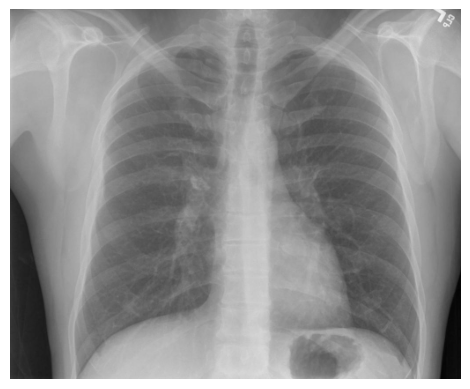

Generated report: Findings: the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.
Impression: 1. no evidence of active disease.


In [28]:
report = trainer.robust_generate_radiology_report(
    image_input="/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1007_IM-0008-1001.png",
    max_tokens=100,
    temperature_range=(0.5, 1.5),
    deterministic=True,
    show_image=True
)
print("Generated report:", report)

In [29]:
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import word_tokenize
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=10):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths = batch['image_path']  # Ensure this exists and is batch-aligned

        for i in range(len(image_paths)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # Load image from the image path
            image_path = image_paths[i]
            pil_img = Image.open(image_path).convert('RGB')

            # Generate report from the image
            gen_report = trainer.robust_generate_radiology_report(
                pil_img,
                max_tokens=500,
                temperature_range=(0.5, 1.5),
                deterministic=True
            )

            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)

            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)

            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(combined_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)


Evaluating dataset:   1%|          | 1/188 [04:49<15:02:41, 289.63s/it]

     BLEU-1    BLEU-2    BLEU-3    BLEU-4    METEOR   ROUGE-L
0  0.253037  0.141419  0.062645  0.022929  0.248261  0.304348
1  0.253037  0.141419  0.062645  0.022929  0.248261  0.304348
2  0.253037  0.141419  0.062645  0.022929  0.248261  0.304348
3  0.253037  0.141419  0.062645  0.022929  0.248261  0.304348
4  0.428559  0.243977  0.144063  0.091194  0.376000  0.289855
5  0.428559  0.243977  0.144063  0.091194  0.376000  0.289855
6  0.499838  0.320258  0.178516  0.109980  0.409925  0.358209
7  0.499838  0.320258  0.178516  0.109980  0.409925  0.358209
8  0.435897  0.185507  0.046732  0.022545  0.407550  0.262295
9  0.435897  0.185507  0.046732  0.022545  0.407550  0.262295
Average Scores: {'BLEU-1': 0.3740735164145428, 'BLEU-2': 0.2065163008129754, 'BLEU-3': 0.09892018677477951, 'BLEU-4': 0.05391553254912984, 'METEOR': 0.33799950136396084, 'ROUGE-L': 0.30381095236575495}


In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images = sample_batch['image']
    input_ids = sample_batch['input_ids']

    total_samples = min(num_samples, images.size(0))
    selected_indices = random.sample(range(images.size(0)), total_samples)

    for idx in selected_indices:
        # Get image tensor and decode ground truth report
        image_tensor = images[idx]
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Reverse normalization for visualization
        image_disp = (image_tensor * std) + mean
        image_disp = transforms.ToPILImage()(image_disp)

        # Save image temporarily
        temp_path = "temp_image.png"
        image_disp.save(temp_path)

        # Generate report using your trainer
        generated_report = trainer.robust_generate_radiology_report(
            image_input=temp_path,
            max_tokens=500,
            temperature_range=(0.8, 1.5),
            deterministic=True,
            show_image=False  # We'll handle visualization here
        )

        # Plot image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_disp)
        plt.axis('off')
        plt.title("Validation Sample Image")
        plt.show()

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)

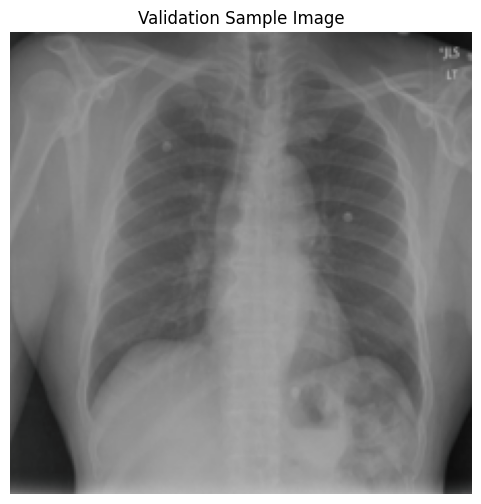


--- Ground Truth Report ---
cardiomediastinal silhouette demonstrates normal heart size with tortuosity and atherosclerosis of the thoracic aorta. no focal consolidation, pneumothorax, or pleural effusion. no acute bony abnormality identified. multilevel degenerative disc disease of the thoracic spine noted.  no acute cardiopulmonary abnormality.

--- Generated Report ---
Findings: the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.
Impression: 1. no evidence of active disease.
--------------------------------------------------------------------------------


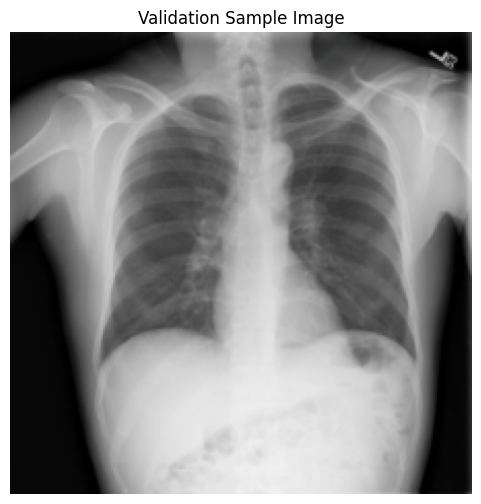


--- Ground Truth Report ---
heart size within normal limits, stable mediastinal and hilar contours. no alveolar consolidation, no findings of pleural effusion or pulmonary edema. no pneumothorax. small rounded bilateral axillary densities not seen on the previous exam most suggestive of artifacts, healed right lateral 10th rib fracture noted..  no acute cardiopulmonary findings

--- Generated Report ---
Findings: the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.
Impression: 1. no evidence of active disease.
--------------------------------------------------------------------------------


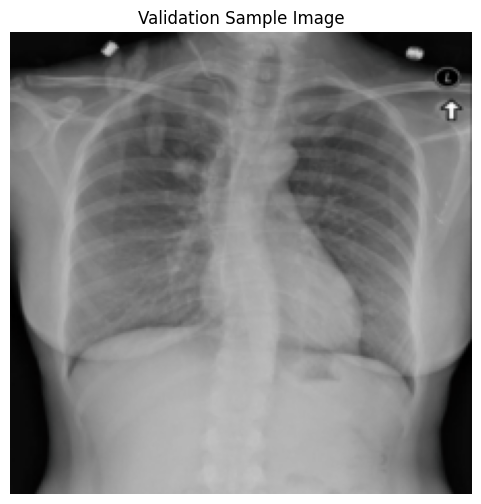


--- Ground Truth Report ---
there are bilateral pulmonary nodules whose appearances suggest metastatic disease to lungs. in the right lung, there is a 1.9 x 2.1 cm nodule overlying the posterior right 6th rib. there is a 1.0 x 1.2 cm nodule above this in the interspace between the posterior 5th and 6th ribs on the right. there is a 1.0 x 1.1 cm nodule projecting through the left 9th and 10th interspaces on the pa view. if not already performed, contrast-enhanced would be suited to evaluate these findings. there are no focal airspace opacities to suggest pneumonia. to the stomach contours appear grossly clear. heart size and pulmonary appear normal. there are left-sided axillary clips. there is a right internal jugular central catheter, the distal tip in right atrium.  1. bilateral pulmonary nodules suggesting pulmonary metastases 2. right internal jugular central catheter, the distal tip in the right atrium.

--- Generated Report ---
Findings: the heart size and pulmonary vascularity 

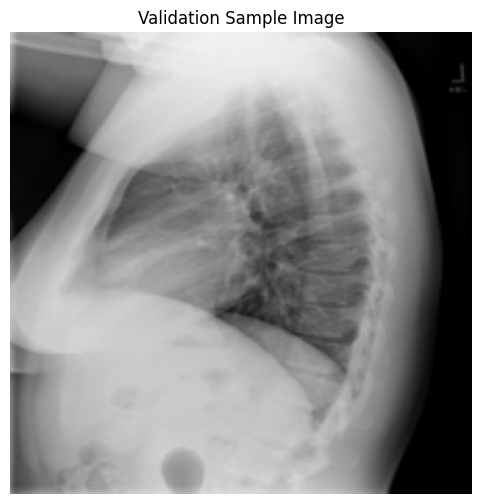


--- Ground Truth Report ---
the lungs and pleural spaces show no acute abnormality. heart size and pulmonary vascularity within normal limits.  1. no acute pulmonary abnormality.

--- Generated Report ---
Findings: the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.
Impression: 1. no evidence of active disease.
--------------------------------------------------------------------------------


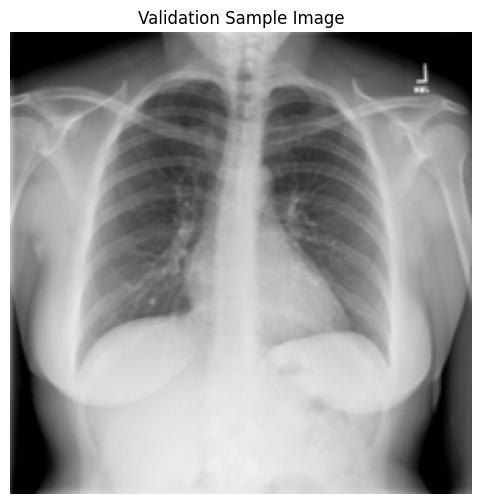


--- Ground Truth Report ---
the lungs and pleural spaces show no acute abnormality. heart size and pulmonary vascularity within normal limits.  1. no acute pulmonary abnormality.

--- Generated Report ---
Findings: the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen.
Impression: 1. no evidence of active disease.
--------------------------------------------------------------------------------


In [31]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)